Import Libraries:

In [1]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from sklearn.utils import shuffle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from Bio import SeqIO
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, Dropout, MaxPooling1D, Flatten, Dense, LayerNormalization, BatchNormalization, Activation
import os
import random
from  keras.regularizers import l2


Load Data:

In [2]:
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

train = pd.read_csv('../Embeddings/Prot_t5/train_t5.csv')
val = pd.read_csv('../Embeddings/Prot_t5/val_t5.csv')
test = pd.read_csv('../Embeddings/Prot_t5/test_t5.csv')

print(train.shape)
print(val.shape)
print(test.shape)

# Convert the embedding strings to numpy arrays
X_train_embeddings = train['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))
X_val_embeddings = val['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))
X_test_embeddings = test['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))

# Convert to a numpy array if needed
X_train_embeddings = np.stack(X_train_embeddings.values)
X_val_embeddings = np.stack(X_val_embeddings.values)
X_test_embeddings = np.stack(X_test_embeddings.values)

# Extract sequences
X_train = train['sequence'].values
X_val = val['sequence'].values
X_test = test['sequence'].values

# Extract labels
y_train = train['label'].values
y_val = val['label'].values
y_test = test['label'].values

# Create a dictionary to map amino acids to integers
amino_acids = 'ACDEFGHIKLMNPQRSTVWY-'
aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}

# Convert the sequences to a numerical format and convert to numpy arrays
X_train_num = [[aa_to_int[aa] for aa in seq] for seq in X_train]
X_val_num = [[aa_to_int[aa] for aa in seq] for seq in X_val]
X_test_num = [[aa_to_int[aa] for aa in seq] for seq in X_test]

X_train_num = np.array(X_train_num)
X_val_num = np.array(X_val_num)
X_test_num = np.array(X_test_num)

#print shapes
print(X_train_embeddings.shape)
print(X_val_embeddings.shape)
print(X_test_embeddings.shape)
print(X_train_num.shape)
print(X_val_num.shape)
print(X_test_num.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)




(8411, 5)
(935, 5)
(3226, 5)
(8411, 1024)
(935, 1024)
(3226, 1024)
(8411, 33)
(935, 33)
(3226, 33)
(8411,)
(935,)
(3226,)


Utility Functions :

In [3]:
def plot(history):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

In [4]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
def evaluate_model(model, X_val = None, X_val_pt5 = None, y_val=None):
    y_true = y_val
    # Predict probabilities (or logits if using `from_logits=True`).
    if X_val_pt5 is None:
        y_pred_probs = model.predict(X_val)
    elif X_val is None:
        y_pred_probs = model.predict(X_val_pt5)
    else:
        y_pred_probs = model.predict([X_val, X_val_pt5])

    # Convert probabilities/logits to binary predictions (threshold = 0.5).
    y_pred = (y_pred_probs > 0.5).astype(int)

    # If y_true is one-hot encoded, convert it to binary format
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # Check if y_true is one-hot encoded
        y_true = np.argmax(y_true, axis=1)  # Convert one-hot encoded y_true to binary labels

    # Ensure y_pred is also 1D
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred = np.argmax(y_pred, axis=1)  # Convert y_pred to binary labels if necessary

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    auprc = average_precision_score(y_true, y_pred_probs)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Compute Specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Print the results
    print(f'Accuracy: {accuracy}')
    print(f'MCC: {mcc}')
    print(f'AUC: {auc}')
    print(f'AUPRC: {auprc}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'Specificity: {specificity}')
    print(f'F1: {f1}')

    return accuracy, mcc, auc, auprc, precision, recall, specificity, f1

For Inception model:

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 33, 21)    │      1,344 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 33, 32)    │      4,736 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 33, 32)    │        704 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 33, 32)    │      2,048 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 33, 32)    │      3,392 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 33, 32)    │      1,056 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 33, 160)   │          0 │ conv1d[0][0],     │
│ (Concatenate)       │                   │            │ conv1d_1[0][0],   │
│                     │                   │            │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d_3[0][0],   │
│                     │                   │            │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 16, 160)   │          0 │ concatenate[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2560)      │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │     81,952 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     65,600 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 96)        │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         97 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 160,929 (628.63 KB)

 Trainable params: 160,929 (628.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5271 - loss: 0.6912 - val_accuracy: 0.6524 - val_loss: 0.6581
Epoch 2/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6442 - loss: 0.6487 - val_accuracy: 0.6856 - val_loss: 0.6211
Epoch 3/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6800 - loss: 0.6146 - val_accuracy: 0.7155 - val_loss: 0.5865
Epoch 4/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7017 - loss: 0.5845 - val_accuracy: 0.7326 - val_loss: 0.5566
Epoch 5/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7255 - loss: 0.5613 - val_accuracy: 0.7401 - val_loss: 0.5338
Epoch 6/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7279 - loss: 0.5436 - val_accuracy: 0.7465 - val_loss: 0.5201
Epoch 7/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7450 - loss: 0.5289 - val_accuracy: 0.7497 - val_loss: 0.5111
Epoch 8/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7420 - loss: 0.5218 - 

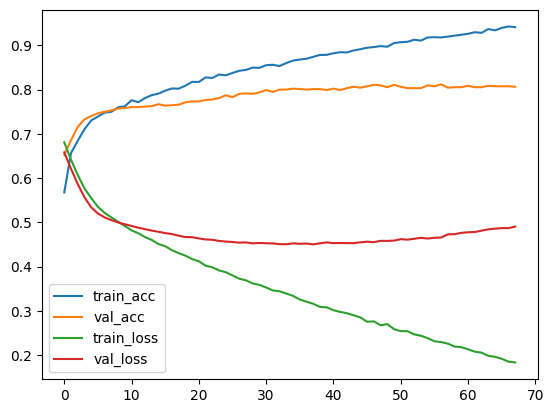

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.8010695187165775
MCC: 0.6010727740193295
AUC: 0.8006715506715508
AUPRC: 0.8635683030792318
Precision: 0.8142857142857143
Recall: 0.8076923076923077
Specificity: 0.7936507936507936
F1: 0.8109756097560976
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7811531308121513
MCC: 0.3557502521783427
AUC: 0.7926676052855142
AUPRC: 0.3101134635526708
Precision: 0.23693379790940766
Recall: 0.8063241106719368
Specificity: 0.7790110998990918
F1: 0.36624775583482944


(0.7811531308121513,
 0.3557502521783427,
 0.7926676052855142,
 0.3101134635526708,
 0.23693379790940766,
 0.8063241106719368,
 0.7790110998990918,
 0.36624775583482944)

In [5]:
import tensorflow as tf
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

def inception_module(input_tensor):
    # Branch 1: Conv1D with kernel size 1
    branch1 = Conv1D(32, kernel_size=1, activation='relu', padding='same')(input_tensor)

    # Branch 2: Conv1D with kernel size 3
    branch2 = Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_tensor)

    # Branch 3: Conv1D with kernel size 5
    branch3 = Conv1D(32, kernel_size=5, activation='relu', padding='same')(input_tensor)

    # Branch 4: Conv1D with kernel size 7
    branch4 = Conv1D(32, kernel_size=7, activation='relu', padding='same')(input_tensor)

    # Branch 5: Conv1D with kernel size 1
    branch5 = Conv1D(32, kernel_size=1, activation='relu', padding='same')(branch4)

    # Concatenate all branches
    output = Concatenate()([branch1, branch2, branch3, branch4, branch5])
    return output

def build_inception_model(input_shape_conv, input_shape_ann):
    # Conv1D branch for sequence data
    conv_input = Input(shape=input_shape_conv)

    # Embedding layer
    x_conv = Embedding(input_dim=64, output_dim=21, input_length=input_shape_conv[0])(conv_input)

    # Apply Inception module instead of Conv1D
    x_conv = inception_module(x_conv)

    # MaxPooling and Flatten layers
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    # Dense layer for sequence features
    x_conv = Dense(32, activation='relu')(x_conv)
    x_conv = Dropout(0.3)(x_conv)

    # ANN branch for prot_t5 embeddings
    ann_input = Input(shape=(input_shape_ann,))

    # Simple Dense layer for ANN features
    x_ann = Dense(64, activation='relu')(ann_input)
    x_ann = Dropout(0.3)(x_ann)

    # Concatenate Conv1D (Inception) and ANN branches
    combined = Concatenate()([x_conv, x_ann])

    # Output layer
    x = Dense(16, activation='relu')(combined)
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(combined)

    # Build model
    model = Model(inputs=[conv_input, ann_input], outputs=output_layer)

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

set_seed(4)

# Define the model with Conv1D input shape (33,) and ANN input shape 1024
inception_model = build_inception_model((33,), 1024)
inception_model.summary()

# Fit the Inception model
history = inception_model.fit([X_train_num, X_train_embeddings], y_train, epochs=1000, batch_size=64, verbose=1,
                               validation_data=([X_val_num, X_val_embeddings], y_val),
                                 callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)],
                            )

plot(history)

evaluate_model(inception_model, X_val_num, X_val_embeddings, y_val)
evaluate_model(inception_model, X_test_num, X_test_embeddings, y_test)


Residual Connections Model :

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 33, 21)    │        441 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 33, 32)    │      2,048 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 33, 32)    │      3,104 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 33, 53)    │          0 │ conv1d_6[0][0],   │
│ (Concatenate)       │                   │            │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 16, 53)    │          0 │ concatenate_2[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 16, 64)    │     10,240 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 16, 64)    │     12,352 │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 117)   │          0 │ conv1d_8[0][0],   │
│ (Concatenate)       │                   │            │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 8, 117)    │          0 │ concatenate_3[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 936)       │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │     29,984 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │     32,800 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 32)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 64)        │          0 │ dropout_3[0][0],  │
│ (Concatenate)       │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         65 │ concatenate_4[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 91,034 (355.60 KB)

 Trainable params: 91,034 (355.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5311 - loss: 0.6912 - val_accuracy: 0.6374 - val_loss: 0.6608
Epoch 2/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6323 - loss: 0.6577 - val_accuracy: 0.6802 - val_loss: 0.6321
Epoch 3/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6555 - loss: 0.6338 - val_accuracy: 0.7005 - val_loss: 0.6079
Epoch 4/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6889 - loss: 0.6109 - val_accuracy: 0.7091 - val_loss: 0.5831
Epoch 5/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7031 - loss: 0.5873 - val_accuracy: 0.7316 - val_loss: 0.5501
Epoch 6/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7152 - loss: 0.5611 - val_accuracy: 0.7401 - val_loss: 0.5240
Epoch 7/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7265 - loss: 0.5411 - val_accuracy: 0.7561 - val_loss: 0.5093
Epoch 8/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7426 - loss: 0.5285 - 

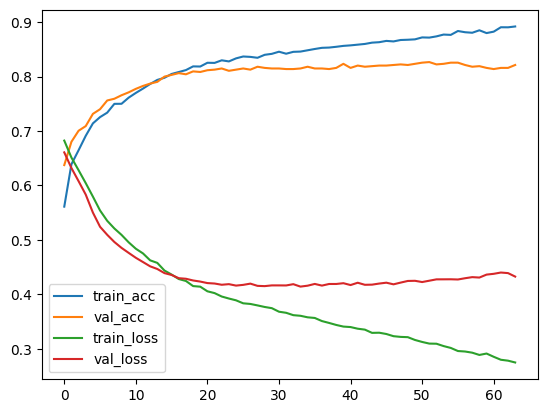

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.8149732620320855
MCC: 0.6285639562509098
AUC: 0.8140727276065622
AUPRC: 0.8769165792859583
Precision: 0.8216432865731463
Recall: 0.8299595141700404
Specificity: 0.7981859410430839
F1: 0.8257804632426989
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.8031618102913826
MCC: 0.3962806708993451
AUC: 0.8190732401893722
AUPRC: 0.338158582408296
Precision: 0.2630272952853598
Recall: 0.8379446640316206
Specificity: 0.8002018163471241
F1: 0.4003777148253069


(0.8031618102913826,
 0.3962806708993451,
 0.8190732401893722,
 0.338158582408296,
 0.2630272952853598,
 0.8379446640316206,
 0.8002018163471241,
 0.4003777148253069)

In [6]:
import tensorflow as tf
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

def residual_block(input_tensor, filters):
    x = Conv1D(filters, kernel_size=3, activation='relu', padding='same')(input_tensor)
    x = Conv1D(filters, kernel_size=3, activation='relu', padding='same')(x)
    x = Concatenate()([x, input_tensor])  # Skip connection
    return x

def build_resnet_model(input_shape_conv, input_shape_ann):
    # Conv1D branch for sequence data
    conv_input = Input(shape=input_shape_conv)
    x_conv = Embedding(input_dim=21, output_dim=21, input_length=input_shape_conv[0])(conv_input)

    # Apply Residual blocks
    x_conv = residual_block(x_conv, 32)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = residual_block(x_conv, 64)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    # Dense layer for sequence features
    x_conv = Dense(32, activation='relu')(x_conv)
    x_conv = Dropout(0.3)(x_conv)

    # ANN branch for prot_t5 embeddings
    ann_input = Input(shape=(input_shape_ann,))
    x_ann = Dense(32, activation='relu')(ann_input)
    x_ann = Dropout(0.3)(x_ann)

    # Concatenate Conv1D (ResNet) and ANN branches
    combined = Concatenate()([x_conv, x_ann])

    # Output layer
    x = Dense(16, activation='relu')(combined)
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(combined)

    # Build model
    model = Model(inputs=[conv_input, ann_input], outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model


set_seed(4)

# Define the model with Conv1D input shape (33,) and ANN input shape 1024
res_model = build_resnet_model((33,), 1024)
res_model.summary()

# Fit the Inception model
history = res_model.fit([X_train_num, X_train_embeddings], y_train, epochs=1000, batch_size=64, verbose=1,
                               validation_data=([X_val_num, X_val_embeddings], y_val),
                                 callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)],
                            )

plot(history)

evaluate_model(res_model, X_val_num, X_val_embeddings, y_val)
evaluate_model(res_model, X_test_num, X_test_embeddings, y_test)


Simple Model:

Epoch 1/1000


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5635 - loss: 0.6834 - val_accuracy: 0.6449 - val_loss: 0.6472
Epoch 2/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6562 - loss: 0.6414 - val_accuracy: 0.6845 - val_loss: 0.6146
Epoch 3/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6757 - loss: 0.6147 - val_accuracy: 0.7048 - val_loss: 0.5916
Epoch 4/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6925 - loss: 0.5945 - val_accuracy: 0.7198 - val_loss: 0.5741
Epoch 5/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7059 - loss: 0.5746 - val_accuracy: 0.7241 - val_loss: 0.5598
Epoch 6/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7134 - loss: 0.5624 - val_accuracy: 0.7273 - val_loss: 0.5460
Epoch 7/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7229 - loss: 0.5480 - val_accuracy: 0.7380 - val_loss: 0.5316
Epoch 8/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7384 - loss: 0.5317 - val_accuracy:

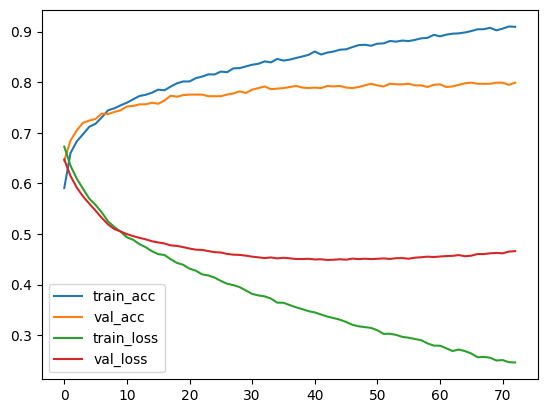

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.7925133689839572
MCC: 0.5837957067722536
AUC: 0.7919661791842243
AUPRC: 0.8567676901397235
Precision: 0.8048780487804879
Recall: 0.8016194331983806
Specificity: 0.782312925170068
F1: 0.8032454361054767
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.7777433353998761
MCC: 0.338492685407859
AUC: 0.7781608920335722
AUPRC: 0.30564307092317794
Precision: 0.2296037296037296
Recall: 0.7786561264822134
Specificity: 0.777665657584931
F1: 0.3546354635463546


(0.7777433353998761,
 0.338492685407859,
 0.7781608920335722,
 0.30564307092317794,
 0.2296037296037296,
 0.7786561264822134,
 0.777665657584931,
 0.3546354635463546)

In [7]:
def build_simple_model(input_shape_conv, input_shape_ann):
    # Conv1D branch for sequence data
    conv_input = Input(shape=input_shape_conv)
    x_conv = Embedding(input_dim=64, output_dim=21, input_length=input_shape_conv[0])(conv_input)
    x_conv = Conv1D(32, kernel_size=3, activation='relu', padding='same')(x_conv)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x_conv)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    # Dense layer for sequence features
    x_conv = Dense(32, activation='relu')(x_conv)
    x_conv = Dropout(0.3)(x_conv)

    # ANN branch for prot_t5 embeddings
    ann_input = Input(shape=(input_shape_ann,))
    x_ann = Dense(64, activation='relu')(ann_input)
    x_ann = Dropout(0.3)(x_ann)

    # Concatenate Conv1D and ANN branches
    combined = Concatenate()([x_conv, x_ann])

    # Output layer
    x = Dense(16, activation='relu')(combined)
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(combined)

    # Build model
    model = Model(inputs=[conv_input, ann_input], outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model




set_seed(4)

# Define the model with Conv1D input shape (33,) and ANN input shape 1024
simple_model = build_simple_model((33,), 1024)
# inception_model.summary()

# Fit the Inception model
history = simple_model.fit([X_train_num, X_train_embeddings], y_train, epochs=1000, batch_size=64, verbose=1,
                               validation_data=([X_val_num, X_val_embeddings], y_val),
                                 callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)],
                            )

plot(history)

evaluate_model(simple_model, X_val_num, X_val_embeddings, y_val)
evaluate_model(simple_model, X_test_num, X_test_embeddings, y_test)

Croos Validation:

In [15]:
#croos validation
from sklearn.model_selection import KFold
import numpy as np

# Define the number of splits for cross-validation
n_splits = 10
kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)


# Perform cross-validation in a function
def cross_validate_model(model_name, X, X_pt5, y, kf):
    set_seed(4)
    accuracies = []
    mccs = []
    aucs = []
    aucprs = []
    precisions = []
    recalls = []
    specificities = []
    f1s = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        X_train_pt5, X_val_pt5 = X_pt5[train_index], X_pt5[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # reinitialize the model
        if model_name == 'inception_model':
            model = build_inception_model((33,), 1024)
        elif model_name == 'res_model':
            model = build_resnet_model((33,), 1024)
        elif model_name == 'simple_model':
            model = build_simple_model((33,), 1024)
            
        # Fit the model
        model.fit([X_train, X_train_pt5], y_train, epochs=1000, batch_size=64, verbose=0,
                  validation_data=([X_val, X_val_pt5], y_val),
                  callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)])

        # Evaluate the model
        print("Validation results:")
        accuracy, mcc, auc, auprc, precision, recall, specificity, f1 = evaluate_model(model, X_val, X_val_pt5, y_val)
        print("Test results:")
        evaluate_model(model, X_test_num, X_test_embeddings, y_test)
        # Append the results to the lists
        accuracies.append(accuracy)
        mccs.append(mcc)
        aucs.append(auc)
        aucprs.append(auprc)
        precisions.append(precision)
        recalls.append(recall)
        specificities.append(specificity)
        f1s.append(f1)
    # Print the average results +- standard deviation
    print("Average results:")
    print(f'Accuracy: {np.mean(accuracies)} +- {np.std(accuracies)}')
    print(f'MCC: {np.mean(mccs)} +- {np.std(mccs)}')
    print(f'AUC: {np.mean(aucs)} +- {np.std(aucs)}')
    print(f'AUPRC: {np.mean(aucprs)} +- {np.std(aucprs)}')
    print(f'Precision: {np.mean(precisions)} +- {np.std(precisions)}')
    print(f'Recall: {np.mean(recalls)} +- {np.std(recalls)}')
    print(f'Specificity: {np.mean(specificities)} +- {np.std(specificities)}')
    print(f'F1: {np.mean(f1s)} +- {np.std(f1s)}')

# Perform cross-validation for the Inception model
print("Inception model:")
cross_validate_model('inception_model', X_train_num, X_train_embeddings, y_train, kf)

# Perform cross-validation for the ResNet model
print("ResNet model:")
cross_validate_model('res_model', X_train_num, X_train_embeddings, y_train, kf)

# Perform cross-validation for the Simple model
print("Simple model:")
cross_validate_model('simple_model', X_train_num, X_train_embeddings, y_train, kf)

Inception model:


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.7764705882352941
MCC: 0.5531678599313777
AUC: 0.7764852028770658
Precision: 0.76875
Recall: 0.7901498929336188
Specificity: 0.7628205128205128
F1: 0.7793030623020063
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7783632982021079
MCC: 0.3391544897877525
AUC: 0.7784972526121124
Precision: 0.23014018691588786
Recall: 0.7786561264822134
Specificity: 0.7783383787420114
F1: 0.3552750225428314


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.7978609625668449
MCC: 0.595737965466303
AUC: 0.797896244634211
Precision: 0.8038379530916845
Recall: 0.7953586497890295
Specificity: 0.8004338394793926
F1: 0.799575821845175
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7820830750154991
MCC: 0.34900329805963154
AUC: 0.7859397289704839
Precision: 0.23529411764705882
Recall: 0.7905138339920948
Specificity: 0.7813656239488732
F1: 0.3626473254759746


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.774331550802139
MCC: 0.5480504882659762
AUC: 0.7737490038745842
Precision: 0.7748478701825557
Recall: 0.7925311203319502
Specificity: 0.7549668874172185
F1: 0.7835897435897435
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7439553626782393
MCC: 0.3281190071296925
AUC: 0.7815264920516534
Precision: 0.21089808274470231
Recall: 0.8260869565217391
Specificity: 0.7369660275815675
F1: 0.3360128617363344


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.7871657754010695
MCC: 0.5747019009549935
AUC: 0.7870510180736674
Precision: 0.7770961145194274
Recall: 0.8085106382978723
Specificity: 0.7655913978494624
F1: 0.7924921793534933
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7337259764414135
MCC: 0.31494065680873107
AUC: 0.7723603339143199
Precision: 0.20294117647058824
Recall: 0.8181818181818182
Specificity: 0.7265388496468214
F1: 0.32521602513747055


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.7754010695187166
MCC: 0.5521322309694675
AUC: 0.7758714596949892
Precision: 0.75564681724846
Recall: 0.8017429193899782
Specificity: 0.75
F1: 0.7780126849894292
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7588344699318041
MCC: 0.3210846011510107
AUC: 0.7697099986838065
Precision: 0.21498371335504887
Recall: 0.782608695652174
Specificity: 0.756811301715439
F1: 0.3373083475298126


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.7935828877005348
MCC: 0.5871239671382333
AUC: 0.7934410550689621
Precision: 0.7904564315352697
Recall: 0.8054968287526427
Specificity: 0.7813852813852814
F1: 0.7979057591623037
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7746435213887167
MCC: 0.33521098168772023
AUC: 0.7764790891408713
Precision: 0.2269585253456221
Recall: 0.7786561264822134
Specificity: 0.774302051799529
F1: 0.3514719000892061


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.7826552462526767
MCC: 0.5687481717714251
AUC: 0.7833608512199596
Precision: 0.7534516765285996
Recall: 0.8304347826086956
Specificity: 0.7362869198312236
F1: 0.7900723888314375
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7523248605083696
MCC: 0.32831674491092666
AUC: 0.7788349426791054
Precision: 0.21443514644351463
Recall: 0.8102766798418972
Specificity: 0.7473932055163135
F1: 0.3391232423490488


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.778372591006424
MCC: 0.5543251049266502
AUC: 0.7765563633517351
Precision: 0.7843137254901961
Recall: 0.8048289738430584
Specificity: 0.7482837528604119
F1: 0.7944389275074478
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7675139491630503
MCC: 0.3278300052252214
AUC: 0.772610942487659
Precision: 0.22109988776655443
Recall: 0.7786561264822134
Specificity: 0.7665657584931046
F1: 0.34440559440559443


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.7708779443254818
MCC: 0.5395917947892788
AUC: 0.7677319895998711
Precision: 0.7645951035781544
Recall: 0.8202020202020202
Specificity: 0.715261958997722
F1: 0.7914230019493177
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7526348419094855
MCC: 0.31894277498710577
AUC: 0.7699626014898248
Precision: 0.21164021164021163
Recall: 0.7905138339920948
Specificity: 0.7494113689875547
F1: 0.333889816360601


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 
Accuracy: 0.7569593147751607
MCC: 0.5156107151586974
AUC: 0.7574344157035406
Precision: 0.7363083164300203
Recall: 0.7891304347826087
Specificity: 0.7257383966244726
F1: 0.7618048268625394
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7662740235585865
MCC: 0.3401495838416597
AUC: 0.7845949514005497
Precision: 0.22442244224422442
Recall: 0.8063241106719368
Specificity: 0.7628657921291625
F1: 0.35111876075731496
Average results:
Accuracy: 0.7793677930584343 +- 0.011137245603683272
MCC: 0.5589190199372402 +- 0.02228089233382266
AUC: 0.7789577604098585 +- 0.011362785662630062
Precision: 0.7709304008604367 +- 0.018652939282840553
Recall: 0.8038386260931475 +- 0.012682855787686154
Specificity: 0.7540768947265698 +- 0.02404345132387271
F1: 0.7868618396392894 +- 0.010852840504948853
ResNet model:


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.7957219251336899
MCC: 0.591452757029113
AUC: 0.7957182598510222
Precision: 0.7974137931034483
Recall: 0.7922912205567452
Specificity: 0.7991452991452992
F1: 0.7948442534908701
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7985120892746436
MCC: 0.3656337272270923
AUC: 0.7930451800060891
Precision: 0.25031446540880503
Recall: 0.7865612648221344
Specificity: 0.7995290951900438
F1: 0.3797709923664122


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.8106951871657754
MCC: 0.6218122160880334
AUC: 0.8103165014598607
Precision: 0.7987927565392354
Recall: 0.8375527426160337
Specificity: 0.7830802603036876
F1: 0.8177136972193615
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7796032238065717
MCC: 0.3714149043480675
AUC: 0.8080996425005551
Precision: 0.2409502262443439
Recall: 0.841897233201581
Specificity: 0.774302051799529
F1: 0.37467018469656993


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.7978609625668449
MCC: 0.5952706236224471
AUC: 0.797101847526403
Precision: 0.7935871743486974
Recall: 0.8215767634854771
Specificity: 0.7726269315673289
F1: 0.8073394495412844
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7690638561686299
MCC: 0.35457039702778925
AUC: 0.7969571997782413
Precision: 0.23026315789473684
Recall: 0.8300395256916996
Specificity: 0.763874873864783
F1: 0.3605150214592275


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.8032085561497326
MCC: 0.6075238344836618
AUC: 0.8030313429421185
Precision: 0.786
Recall: 0.8361702127659575
Specificity: 0.7698924731182796
F1: 0.8103092783505155
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7647241165530069
MCC: 0.350150690009117
AUC: 0.79460267572846
Precision: 0.2267818574514039
Recall: 0.8300395256916996
Specificity: 0.7591658257652203
F1: 0.356234096692112


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.8042780748663102
MCC: 0.6104486182926832
AUC: 0.8048552754435108
Precision: 0.7804878048780488
Recall: 0.8366013071895425
Specificity: 0.773109243697479
F1: 0.807570977917981
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7799132052076876
MCC: 0.3563447794025039
AUC: 0.7938029884241441
Precision: 0.2364475201845444
Recall: 0.8102766798418972
Specificity: 0.7773292970063909
F1: 0.36607142857142855


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.8021390374331551
MCC: 0.6042213349111623
AUC: 0.8020235578375112
Precision: 0.8
Recall: 0.8118393234672304
Specificity: 0.7922077922077922
F1: 0.8058761804826863
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.782703037817731
MCC: 0.34578789088643835
AUC: 0.782659880957604
Precision: 0.23459715639810427
Recall: 0.782608695652174
Specificity: 0.782711066263034
F1: 0.3609845031905196


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.8104925053533191
MCC: 0.6259106051769047
AUC: 0.8113327829756007
Precision: 0.7747572815533981
Recall: 0.8673913043478261
Specificity: 0.7552742616033755
F1: 0.8184615384615385
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7721636701797893
MCC: 0.3635399118667945
AUC: 0.8040633155580728
Precision: 0.23458149779735682
Recall: 0.841897233201581
Specificity: 0.7662293979145645
F1: 0.3669250645994832


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.8008565310492506
MCC: 0.5995655788615905
AUC: 0.7982356380848017
Precision: 0.7973231357552581
Recall: 0.8390342052313883
Specificity: 0.7574370709382151
F1: 0.8176470588235294
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7836329820210788
MCC: 0.35457748853660687
AUC: 0.7903968390082547
Precision: 0.23792697290930506
Recall: 0.7984189723320159
Specificity: 0.7823747056844937
F1: 0.3666061705989111


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.8019271948608137
MCC: 0.6021793061887529
AUC: 0.7992153885092382
Precision: 0.7946768060836502
Recall: 0.8444444444444444
Specificity: 0.7539863325740319
F1: 0.8188050930460333
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7672039677619343
MCC: 0.3565095003011658
AUC: 0.799564326634041
Precision: 0.2299349240780911
Recall: 0.8379446640316206
Specificity: 0.7611839892364615
F1: 0.3608510638297872


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.7591006423982869
MCC: 0.5181501139542407
AUC: 0.7590946615299945
Precision: 0.7537796976241901
Recall: 0.758695652173913
Specificity: 0.759493670886076
F1: 0.7562296858071506
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.8062616243025419
MCC: 0.38269604869390106
AUC: 0.8044821044206821
Precision: 0.2609254498714653
Recall: 0.8023715415019763
Specificity: 0.8065926673393878
F1: 0.3937924345295829
Average results:
Accuracy: 0.7986280616977177 +- 0.013924483371819455
MCC: 0.597653498860859 +- 0.028417313806125437
AUC: 0.7980925256160062 +- 0.01392495243454291
Precision: 0.7876818449885927 +- 0.013847887013141717
Recall: 0.8245597176278558 +- 0.029048438188893518
Specificity: 0.7716253336041566 +- 0.014984610088536073
F1: 0.8054797213140951 +- 0.017927075317295822
Simple model:


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.7786096256684492
MCC: 0.5572190066631959
AUC: 0.7786082285546955
Precision: 0.778969957081545
Recall: 0.7773019271948608
Specificity: 0.7799145299145299
F1: 0.7781350482315113
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.7755734655920645
MCC: 0.326423538271962
AUC: 0.7679431085301309
Precision: 0.22456140350877193
Recall: 0.758893280632411
Specificity: 0.7769929364278506
F1: 0.34657039711191334


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.8010695187165775
MCC: 0.6021186231285504
AUC: 0.8008525769515913
Precision: 0.7962962962962963
Recall: 0.8164556962025317
Specificity: 0.7852494577006508
F1: 0.80625
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.7861128332300062
MCC: 0.3534267903320448
AUC: 0.7881260727309952
Precision: 0.23894862604540024
Recall: 0.7905138339920948
Specificity: 0.7857383114698957
F1: 0.3669724770642202


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.7796791443850267
MCC: 0.5587669762507838
AUC: 0.7790685425883689
Precision: 0.7793522267206477
Recall: 0.7987551867219918
Specificity: 0.7593818984547461
F1: 0.7889344262295082
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.7634841909485431
MCC: 0.3469786502908437
AUC: 0.7921218502756695
Precision: 0.2252155172413793
Recall: 0.8260869565217391
Specificity: 0.7581567440295998
F1: 0.3539373412362405


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.7925133689839572
MCC: 0.5850915364294516
AUC: 0.7925417524593914
Precision: 0.7974137931034483
Recall: 0.7872340425531915
Specificity: 0.7978494623655914
F1: 0.7922912205567452
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7628642281463113
MCC: 0.32702397295600977
AUC: 0.7737044467400278
Precision: 0.21868131868131868
Recall: 0.7865612648221344
Specificity: 0.7608476286579213
F1: 0.3422184006878762


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.8042780748663102
MCC: 0.6102391375087405
AUC: 0.8048163709928415
Precision: 0.7816326530612245
Recall: 0.8344226579520697
Specificity: 0.7752100840336135
F1: 0.8071654373024236
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.7560446373217607
MCC: 0.31446736856652285
AUC: 0.7645801674889552
Precision: 0.21166306695464362
Recall: 0.7747035573122529
Specificity: 0.7544567776656576
F1: 0.3324851569126378


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.7807486631016043
MCC: 0.5614413851637502
AUC: 0.7806050538608678
Precision: 0.7780082987551867
Recall: 0.7928118393234672
Specificity: 0.7683982683982684
F1: 0.7853403141361257
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7737135771853689
MCC: 0.34201146049078657
AUC: 0.7832069654559015
Precision: 0.22866894197952217
Recall: 0.7944664031620553
Specificity: 0.7719475277497477
F1: 0.3551236749116608


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.7794432548179872
MCC: 0.5605556172194839
AUC: 0.7799073564483582
Precision: 0.758130081300813
Recall: 0.8108695652173913
Specificity: 0.7489451476793249
F1: 0.7836134453781513
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7582145071295723
MCC: 0.30095317000354904
AUC: 0.7512925951481649
Precision: 0.2081949058693245
Recall: 0.7430830039525692
Specificity: 0.7595021863437605
F1: 0.32525951557093424


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.7687366167023555
MCC: 0.535433201488689
AUC: 0.7676401659384223
Precision: 0.781563126252505
Recall: 0.7847082494969819
Specificity: 0.7505720823798627
F1: 0.7831325301204819
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.7768133911965283
MCC: 0.3394509518785277
AUC: 0.779464455461472
Precision: 0.22943221320973348
Recall: 0.782608695652174
Specificity: 0.7763202152707702
F1: 0.3548387096774194


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.771948608137045
MCC: 0.5415569697233461
AUC: 0.7696440486873288
Precision: 0.7722007722007722
Recall: 0.8080808080808081
Specificity: 0.7312072892938497
F1: 0.7897334649555775
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.7560446373217607
MCC: 0.32611263153430814
AUC: 0.7754287932632161
Precision: 0.21535181236673773
Recall: 0.7984189723320159
Specificity: 0.7524386141944164
F1: 0.33921074727120065


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation results:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.7483940042826552
MCC: 0.49904401273421356
AUC: 0.7489634929370759
Precision: 0.7254509018036072
Recall: 0.7869565217391304
Specificity: 0.7109704641350211
F1: 0.7549530761209593
Test results:
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.7600743955362679
MCC: 0.32036285387000146
AUC: 0.7685746155451766
Precision: 0.21530054644808744
Recall: 0.7786561264822134
Specificity: 0.7584931046081399
F1: 0.3373287671232877
Average results:
Accuracy: 0.7805420879661968 +- 0.015428964897653715
MCC: 0.5611466466310204 +- 0.030960188111365167
AUC: 0.7802647589418941 +- 0.01560042347665875
Precision: 0.7749018106576047 +- 0.019581051866316413
Recall: 0.7997596494482424 +- 0.016655149031365914
Specificity: 0.7607698684355458 +- 0.024913949964877134
F1: 0.7869548963031484 +- 0.013968432987466183
